交通流量预测     
JetRail高铁的乘客数量预测    
数据集：jetrail.csv    
根据过往3年的数据（2012 年 1 月至 2014 年 12月），需要用这些数据预测接下来 7 个月的乘客数量    
以每天为单位聚合数据集

In [1]:
from datetime import datetime

import pandas as pd
from fbprophet import Prophet
from statsmodels.api import tsa
from matplotlib import pyplot as plt

from fbprophet.plot import plot_forecast_component # 绘制单成分

from fbprophet.plot import add_changepoints_to_plot # 显示突变点

from chinese_calendar import get_holidays

from chinese_calendar import get_holiday_detail

Importing plotly failed. Interactive plots will not work.


In [2]:
# 设置显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 准备数据

## 加载数据

In [3]:
df = pd.read_csv('train.csv',
                 index_col='ID',
                 parse_dates=['Datetime'])

In [4]:
df.head(2)

,Datetime,Count
ID,,
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2


In [5]:
df = df.set_index('Datetime')

In [6]:
df.tail(1)

,Count
Datetime,
2014-09-25 23:00:00,534


In [7]:
df['Count'].isnull().sum()

0

In [8]:
df.shape

(18288, 1)

In [9]:
# 日期的最小值
df.index.min()

Timestamp('2012-01-09 00:00:00')

In [10]:
# 日期的最大值
df.index.max()

Timestamp('2014-12-09 23:00:00')

In [11]:
df = df.sort_index()

In [12]:
df.head(2)

,Count
Datetime,
2012-01-09 00:00:00,8
2012-01-09 01:00:00,4


In [13]:
df.tail(2)

,Count
Datetime,
2014-12-09 22:00:00,410
2014-12-09 23:00:00,368


In [14]:
# 有数据的天数共762天
len(set(df.index.date))

762

## 按天重采样——日乘客数

In [15]:
df_day = df.resample("D").sum()

In [16]:
print(df_day.shape)
df_day.head(2)

(1066, 1)


,Count
Datetime,
2012-01-09,112
2012-01-10,248


In [17]:
df_day['Count'].isnull().sum()

0

In [18]:
# 304天数据是缺失的
(df_day['Count'] == 0).sum()

304

In [19]:
df_day.loc['2012-01-13']

Count    0
Name: 2012-01-13 00:00:00, dtype: int64

In [20]:
df.loc['2012-01-13']

,Count
Datetime,


重采样时，求均值时，如果当日没有数据，返回将是**空值NaN**；如果求和，当日没数据时，得到的是0.

## 查看序列情况

### 可视化查看时间序列概况

In [21]:
temp = df_day['Count'].interpolate()

In [22]:
result = tsa.seasonal_decompose(x=temp)

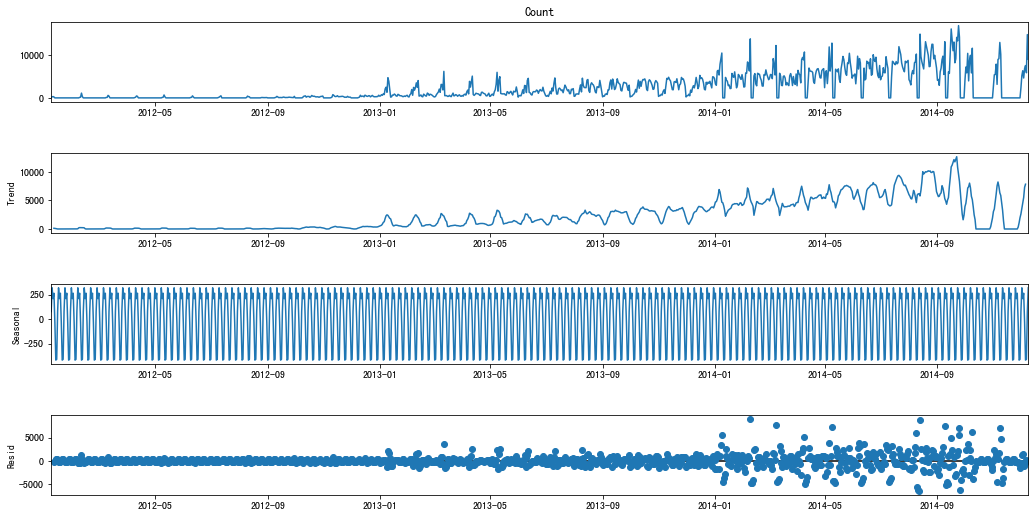

In [23]:
fig = result.plot()
# 修改图像的高度和宽度
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

### 时间序列的ADF检验（单位根检验）

In [24]:
adf = tsa.stattools.adfuller(temp)

In [25]:
type(adf), len(adf)

(tuple, 6)

In [26]:
print(f"adf检验统计量为:{adf[0]:.4f}")
print(f"adf检验Pvalue为:{adf[1]:.4f}")
print(f"结果使用的延迟阶数:{adf[2]}")
print(f"ADF回归和计算临界值所使用的观察次数:{adf[3]}")
print(
    f"99%置信度的临界值为:{adf[4]['1%']:.4f} \n95%置信度的临界值为:{adf[4]['5%']:.4f} \n90%置信度的临界值为:{adf[4]['10%']:.4f}"
)
print(f"最大的信息准则AIC的值{adf[5]:.4f}")

adf检验统计量为:-2.9012
adf检验Pvalue为:0.0452
结果使用的延迟阶数:14
ADF回归和计算临界值所使用的观察次数:1051
99%置信度的临界值为:-3.4366 
95%置信度的临界值为:-2.8643 
90%置信度的临界值为:-2.5682
最大的信息准则AIC的值18592.9535


- **确定该序列能否平稳主要看以下几点：**
    - 1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设；本数据中，adf结果为-2.9012， 大于1%、5%和10%的level统计值，说明序列不平稳。
    - P-value是否非常接近0，本数据中，P-value 为 0.0452，大于0，也可以说明序列不平稳
    - ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。
    - 对于ADF结果在1% 以上 5%以下的结果，也不能说不平稳，关键看检验要求是什么样子的。
- ADF检验只适合AR(P)模型，当检验结果是平稳序列时，则适用于 AR模型。

## 重置index

In [27]:
# 将index重置为数字索引，时间索引恢复为时间列
df_day = df_day.reset_index()

In [28]:
df_day.head(2)

,Datetime,Count
0,2012-01-09,112
1,2012-01-10,248


## 将列名重命名为'ds', 'y'

In [29]:
# 重命名列名
df_day.columns=['ds', 'y']

In [30]:
df_day.head(2)

,ds,y
0,2012-01-09,112
1,2012-01-10,248


In [31]:
df_day.tail(2)

,ds,y
1064,2014-12-08,14762
1065,2014-12-09,9010


# 拆分训练集和测试集

时间序列模型拆分数据集时，只能连续拆分，不能用sklearn的train_test_split

In [32]:
# 取最后90天的数据做测试集
test_df = df_day.copy()
train_df = df_day.iloc[:-90, :]

train_df.shape

(976, 2)

In [33]:
train_df.tail(1)

,ds,y
975,2014-09-10,0


# 建模训练

## 默认参数建模
仅将daily_seasonality设为True，表示周期为日的季节性

In [34]:
model = Prophet()

In [35]:
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
# 默认识别25个突变点的位置，突变点越多，拟合度越高，要警惕过拟合
len(model.changepoints), model.changepoints[:2]

(25,
 31   2012-02-09
 62   2012-03-11
 Name: ds, dtype: datetime64[ns])

### 测试集验证

#### 构建待预测测试数据

In [37]:
test_forcast = model.make_future_dataframe(periods=90, freq='D')

In [38]:
test_forcast.tail(1)

,ds
1065,2014-12-09


#### 对测试数据进行预测

In [39]:
test_forcast = model.predict(test_forcast)

In [40]:
test_forcast.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1064,2014-12-08,8789.977821,6003.394620,10158.381331,8729.884048,8847.159576,-704.986568,-704.986568,-704.986568,87.187363,87.187363,87.187363,-792.173931,-792.173931,-792.173931,0.0,0.0,0.0,8084.991253
1065,2014-12-09,8804.494837,6240.104663,10448.963812,8743.362860,8862.651373,-512.025224,-512.025224,-512.025224,270.839026,270.839026,270.839026,-782.864249,-782.864249,-782.864249,0.0,0.0,0.0,8292.469614


In [41]:
# 直接对测试用的DataFrame进行预测
test_df_forcast = model.predict(test_df)
test_df_forcast.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1064,2014-12-08,8789.977821,6049.138541,10135.107228,8741.222437,8851.555532,-704.986568,-704.986568,-704.986568,87.187363,87.187363,87.187363,-792.173931,-792.173931,-792.173931,0.0,0.0,0.0,8084.991253
1065,2014-12-09,8804.494837,6095.356596,10477.461426,8754.733768,8866.895235,-512.025224,-512.025224,-512.025224,270.839026,270.839026,270.839026,-782.864249,-782.864249,-782.864249,0.0,0.0,0.0,8292.469614


In [42]:
test_df_forcast.shape, test_forcast.shape

((1066, 19), (1066, 19))

可见，对测试集，我们不需要重复构建测试集的待预测数据，直接对测试数据集进行预测即可，结果一致。

#### 可视化测试集预测效果

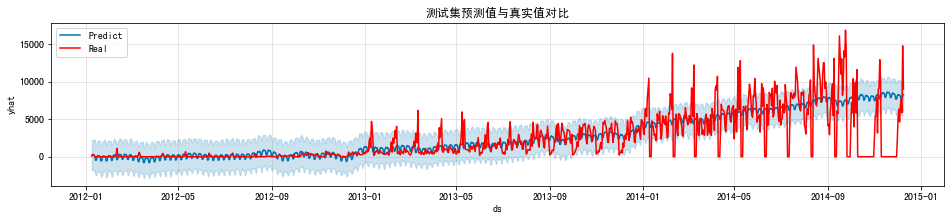

In [43]:
# 返回包含matplotlib.lines.Line2D对象的列表
line = plot_forecast_component(model, test_forcast, 'yhat', figsize=(16, 3))
# 调用Line2D对象的axes的方法在该轴上继续绘制
line2 = line[0].axes.plot(df_day.set_index('ds')['y'], color='r')
line2[0].axes.legend(['Predict', 'Real'])
line2[0].axes.set_title("测试集预测值与真实值对比")
plt.show()

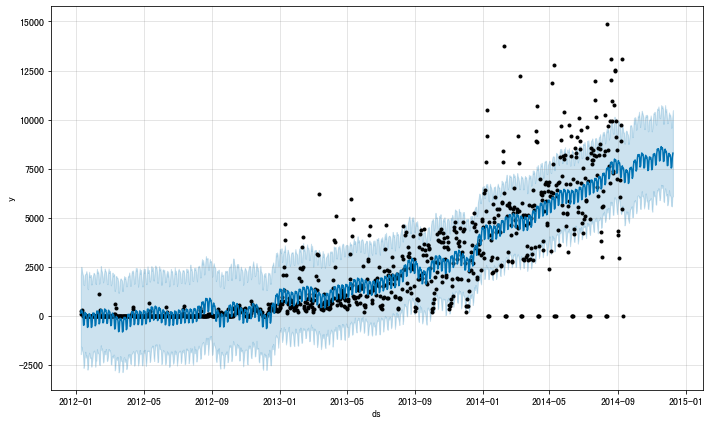

In [45]:
f = model.plot(test_df_forcast)
plt.show()

### 预测未来7个月乘客日数量

In [46]:
df_day.tail(1)

,ds,y
1065,2014-12-09,9010


In [47]:
last_day = train_df['ds'][len(train_df) - 1]
last_day

Timestamp('2014-09-10 00:00:00')

In [48]:
future_end = datetime(2015, 7, 31)

In [49]:
delta = future_end - last_day
delta

Timedelta('324 days 00:00:00')

In [50]:
future = model.make_future_dataframe(delta.days, freq='D')
future.tail(1)

,ds
1299,2015-07-31


In [51]:
future = model.predict(future)

In [52]:
future.shape

(1300, 19)

In [53]:
future.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1295,2015-07-27,12143.408679,10070.862272,14269.498361,11741.207587,12583.708148,42.007299,42.007299,42.007299,87.187363,87.187363,87.187363,-45.180064,-45.180064,-45.180064,0.0,0.0,0.0,12185.415978
1296,2015-07-28,12157.925696,10231.367552,14497.240903,11753.757186,12600.837995,224.782374,224.782374,224.782374,270.839026,270.839026,270.839026,-46.056652,-46.056652,-46.056652,0.0,0.0,0.0,12382.708070
1297,2015-07-29,12172.442713,10194.022295,14318.952348,11766.194436,12617.392856,123.943389,123.943389,123.943389,169.748983,169.748983,169.748983,-45.805594,-45.805594,-45.805594,0.0,0.0,0.0,12296.386102
1298,2015-07-30,12186.959729,10276.866529,14379.714768,11778.631687,12634.374749,183.993672,183.993672,183.993672,228.200928,228.200928,228.200928,-44.207255,-44.207255,-44.207255,0.0,0.0,0.0,12370.953402
1299,2015-07-31,12201.476746,10027.763031,14295.700945,11791.068938,12651.345713,31.670242,31.670242,31.670242,72.717540,72.717540,72.717540,-41.047298,-41.047298,-41.047298,0.0,0.0,0.0,12233.146988


#### 认识预测结果DataFrame

In [54]:
future.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

- 加法模型，有：
     1. `forecast['additive_terms'] = forecast['weekly'] + forecast['yearly']`；
     1. `forecast['yhat']  = forecast['trend'] +  forecast['additive_terms']` 
     1. `forecast['yhat']  = forecast['trend'] +forecast['weekly'] + forecast['yearly']`
- 加法模型，所以'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper'这3列为空

In [55]:
# 验证第一条，根据结果十分接近于0，所以第一条成立
(future['additive_terms'] - (future['weekly'] + future['yearly'])).sum()

8.448797217397441e-13

In [56]:
# 验证第二条，根据结果为0，所以第二条成立
(future['yhat'] - (future['trend'] + future['additive_terms'])).sum()

0.0

In [57]:
# 验证第三条，根据结果极小，接近于0，所以第三条成立
yhat_sr = future['trend'] + future['weekly'] + future['yearly']
(yhat_sr - future['yhat']).sum()

-2.015276834299584e-11

#### 可视化预测结果

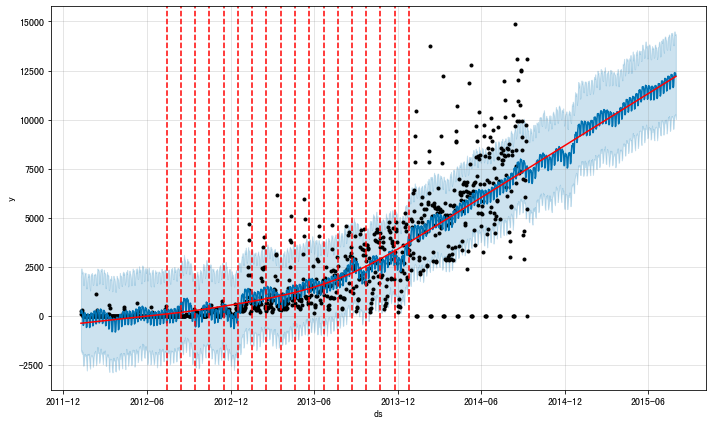

In [58]:
fig = model.plot(future)
# 绘制突变点位置，均匀分布在在前 80% 的时间序列数据中
a = add_changepoints_to_plot(fig.gca(), model, future)
plt.show()

浅蓝色部分是置信区间，浅蓝色的上边界代表预测的置信区间的上边界yhat_upper，浅蓝色的下边界代表预测的置信区间的下边界值yhat_lower；黑色代表真实值；深蓝色的代表预测的平均值。

df_day中存在300多天是0，仍然可以正常预测 ，说明prophet模型确实可以处理缺失数据。

未来7个月，每日乘客数量仍然会呈上升趋势，2015年7月底预计每日乘客数约在10000-14000范围内。

#### 查看预测的成分分析
展示预测中的趋势、周效应和年度效应

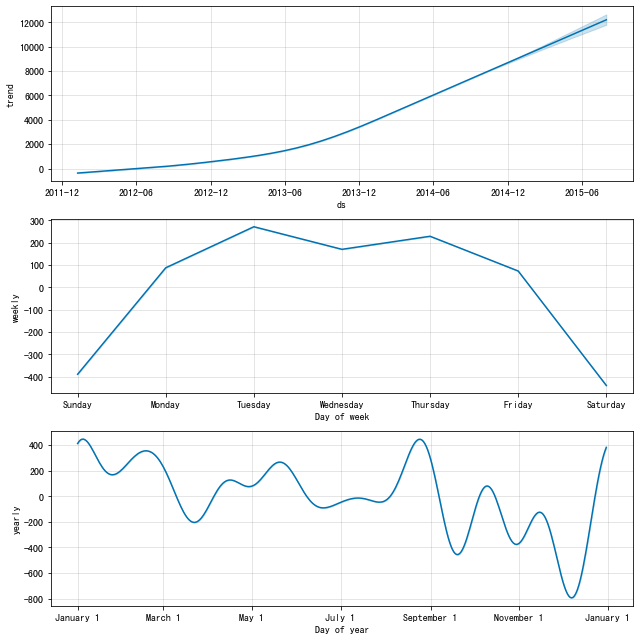

In [59]:
fig = model.plot_components(future)
plt.show()

In [60]:
# 手动绘制趋势、周效应和年度效应
# figs, axes = plt.subplots(3, 1, figsize=(10, 9))
# axes[0].plot(future.set_index('ds')['trend'])
# axes[1].plot(future.set_index('ds')['weekly'][:14])
# axes[2].plot(future.set_index('ds').loc['2013', 'yearly'])

# for i, y in enumerate(["trend", "weekly", "yearly"]):
#     axes[i].set_ylabel(y)
# plt.show()

plot_components绘制的结果，是从future的trend、weekly、yearly三列的取值绘制而得。

预测结果成分分析解读：
- 第一个子图trend趋势图：显示数据呈上升趋势；
- 第二个子图weekly周效应图：显示周末两天客流量较少，周二客流量最高，周三会小幅下降；weekly的值为`x`，表示在trend的基础上，加`x`；x为正数时增加，为负数时表示在trend的基础上减少。因此，weekly这条线的高低反应了客流量的趋势。
- 第三个子图yearly年度效应：1月、3月乘客流量较高；5月底和8月底乘客数量增加。按照我们日常的理解，我们会以为10月因为有国庆，所以数据会高，但这里预测结果是乘客数量很低；下面是绘制的3年中9、10月的真实值，发现3年中国庆数据确实不高，所以预测值低。

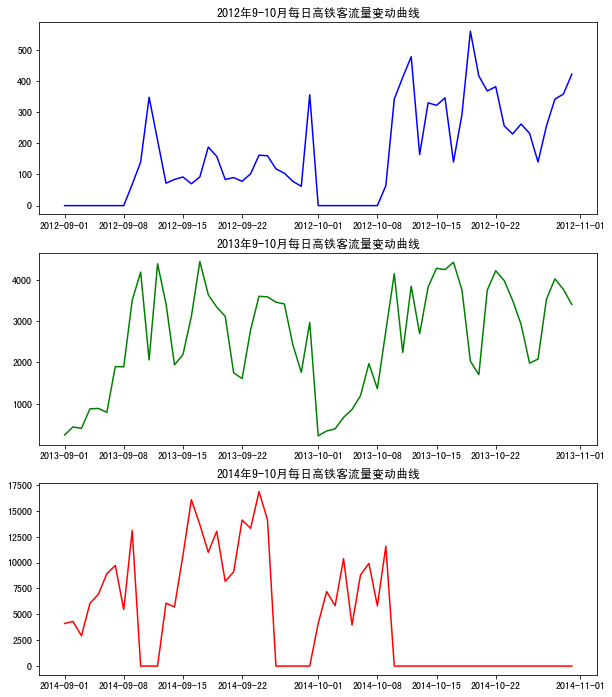

In [61]:
# 2012到14年9月和10月每日乘客流量变动曲线
_, axes = plt.subplots(3, 1, figsize=(10, 12))
axes[0].plot(df_day.set_index('ds').loc['2012-09':'2012-10'],
             color='b')
axes[1].plot(df_day.set_index('ds').loc['2013-09':'2013-10'],
             color='g')
axes[2].plot(df_day.set_index('ds').loc['2014-09':'2014-10'],
             color='r')
for i, y in enumerate(["2012", "2013", "2014"]):
    axes[i].set_title("%s年9-10月每日高铁客流量变动曲线" % y)
plt.show()

## 带假期建模


### 准备假期数据

In [62]:
start = df_day['ds'][0]
end = datetime(2015, 7,31)
start, end

(Timestamp('2012-01-09 00:00:00'), datetime.datetime(2015, 7, 31, 0, 0))

In [63]:
# 获得2012-01-09到2014-12-09中国假期的日期
holidays = get_holidays(start=start, end=end, include_weekends=False)

In [64]:
type(holidays), len(holidays), type(holidays[0])

(list, 90, datetime.date)

In [65]:
get_holiday_detail(holidays[1])

(True, 'Spring Festival')

In [66]:
holidays_name = [get_holiday_detail(day)[1] for day in holidays]

In [67]:
# 保留字段：节假日 holiday 、日期戳 ds、lower_window 以及upper_window
# 将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散
# 国庆和元旦假期肯定休息时间不一致，lower_window 以及upper_window可以理解为假日延长时限，
holiday_df = pd.DataFrame({
    "ds": holidays,
    "holiday": holidays_name,
    "lower_window": -3,
    "upper_window":3
})

In [68]:
holiday_df.tail(2)

,ds,holiday,lower_window,upper_window
88,2015-06-20,Dragon Boat Festival,-3,3
89,2015-06-22,Dragon Boat Festival,-3,3


### 带节假日建模

In [69]:
# 带节假日建模
modelh = Prophet(holidays=holiday_df, daily_seasonality=True, n_changepoints=50)

In [70]:
# 训练集训练
modelh.fit(train_df)

In [71]:
len(modelh.changepoints)

50

### 测试集验证

#### 对测试集预测

In [72]:
# 预测
test_fcst = modelh.predict(test_df)

In [73]:
test_fcst.shape

(1066, 46)

In [74]:
test_fcst.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labour Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-09,-2.453412,-1713.825183,2249.655705,-2.453412,-2.453412,0.0,0.0,0.0,0.0,...,82.240654,82.240654,82.240654,539.36059,539.36059,539.36059,0.0,0.0,0.0,161.583945


#### 测试集预测结果与真实值可视化对比

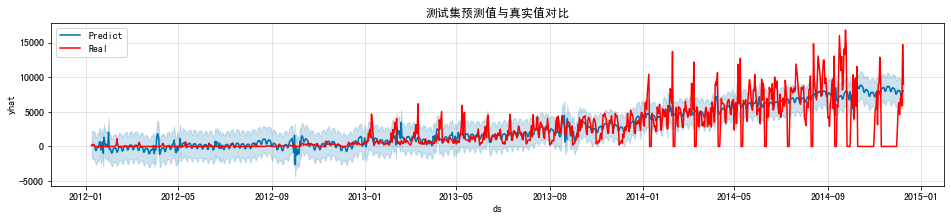

In [75]:
line = plot_forecast_component(modelh, test_fcst, 'yhat', figsize=(16, 3))
line2 = line[0].axes.plot(df_day.set_index('ds')['y'], color='r')
line2[0].axes.legend(['Predict', 'Real'])
line2[0].axes.set_title("测试集预测值与真实值对比")
plt.show()

看起来和没与模型参数建模的预测效果一致

### 预测未来7个月日乘客数量

In [76]:
fcst  = modelh.make_future_dataframe(delta.days, freq='D')

In [77]:
forcast = modelh.predict(fcst)

In [78]:
forcast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labour Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-09,-2.453412,-1629.873003,2155.913423,-2.453412,-2.453412,0.0,0.0,0.0,0.0,...,82.240654,82.240654,82.240654,539.360590,539.360590,539.360590,0.0,0.0,0.0,161.583945
1,2012-01-10,0.705936,-1572.825175,2257.443964,0.705936,0.705936,0.0,0.0,0.0,0.0,...,252.581750,252.581750,252.581750,494.785979,494.785979,494.785979,0.0,0.0,0.0,290.509778


#### 可视化预测结果

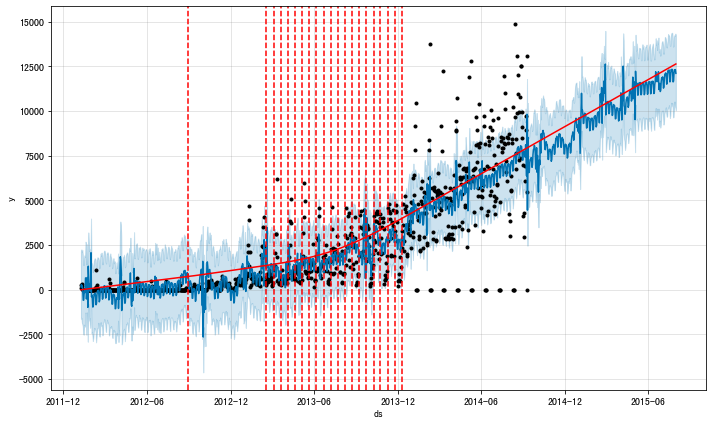

In [79]:
fig = modelh.plot(forcast)
add_changepoints_to_plot(fig.gca(), modelh, forcast)
plt.show()

默认参数模型的深蓝色部分更平滑，而包含节假日模型的预测的深蓝色部分，即预测的均值会有抖动。说明增加节假日数据后的模型，确实拟合程度更高些。

未来7个月内每日乘客数仍然呈现上升趋势。预计2015年7月底，每日乘客数也约在10000~14000范围内；

#### 查看预测的拆分分析

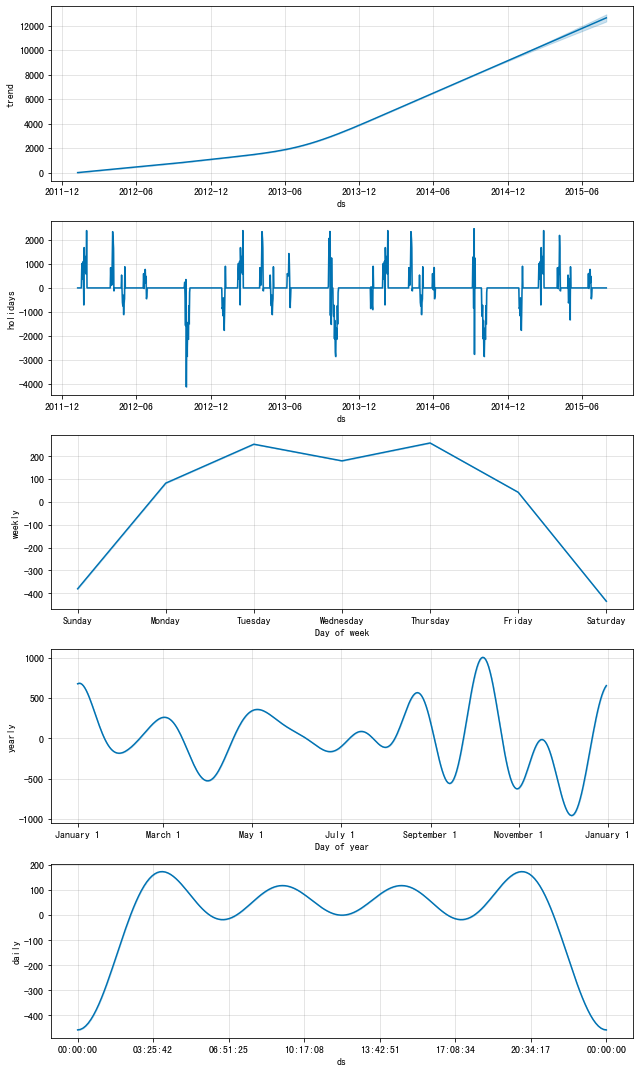

In [80]:
modelh.plot_components(forcast)
plt.show()

#### 看下各节假日的预测情况

In [81]:
forcast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Dragon Boat Festival', 'Dragon Boat Festival_lower',
       'Dragon Boat Festival_upper', 'Labour Day', 'Labour Day_lower',
       'Labour Day_upper', 'Mid-autumn Festival', 'Mid-autumn Festival_lower',
       'Mid-autumn Festival_upper', 'National Day', 'National Day_lower',
       'National Day_upper', 'New Year's Day', 'New Year's Day_lower',
       'New Year's Day_upper', 'Spring Festival', 'Spring Festival_lower',
       'Spring Festival_upper', 'Tomb-sweeping Day', 'Tomb-sweeping Day_lower',
       'Tomb-sweeping Day_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtyp

In [82]:
# 说明每个假期都有预测结果
forcast.loc[:, 'Dragon Boat Festival':'Tomb-sweeping Day_upper'].sum()

Dragon Boat Festival           9533.693829
Dragon Boat Festival_lower     9533.693829
Dragon Boat Festival_upper     9533.693829
Labour Day                    -8396.672941
Labour Day_lower              -8396.672941
Labour Day_upper              -8396.672941
Mid-autumn Festival           10862.700460
Mid-autumn Festival_lower     10862.700460
Mid-autumn Festival_upper     10862.700460
National Day                 -60121.309196
National Day_lower           -60121.309196
National Day_upper           -60121.309196
New Year's Day               -14183.125950
New Year's Day_lower         -14183.125950
New Year's Day_upper         -14183.125950
Spring Festival               47132.310718
Spring Festival_lower         47132.310718
Spring Festival_upper         47132.310718
Tomb-sweeping Day             33432.637692
Tomb-sweeping Day_lower       33432.637692
Tomb-sweeping Day_upper       33432.637692
dtype: float64

In [83]:
# 假期对应的真实值
df_day[df_day['ds'].isin(holiday_df['ds'])]

,ds,y
13,2012-01-22,0
14,2012-01-23,0
15,2012-01-24,0
16,2012-01-25,0
17,2012-01-26,0
...,...,...
998,2014-10-03,5836
999,2014-10-04,10384
1000,2014-10-05,3966
1001,2014-10-06,8792


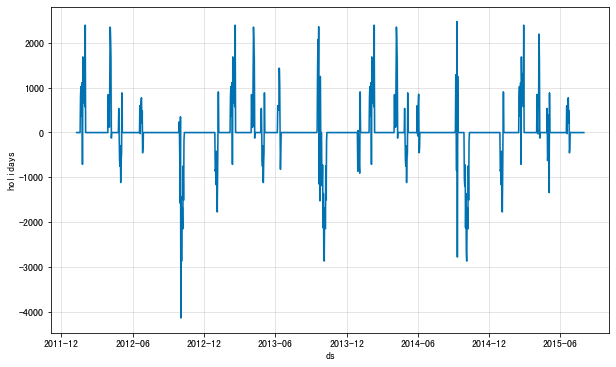

In [84]:
# 单独绘制holidays成分
plot_forecast_component(modelh, forcast, 'holidays')

# 总结
---

1. 读入的数据集第一行样本的时间并不一定是最早的时间，需要查看时间列或时间index的最小值和最大值来识别；
2. 输入模型的数据时间列名必须为ds，待预测的数据列名必须为y；
3. 当数据集中有缺失数据(如：当天数据为0或者NaN)时，Prophet仍然可以进行预测；
4. Prophet模型训练后，可以直接调用实例方法直接生成待预测的时间序列；
5. 可视化中:
    - 既可以对整个预测结果进行可视化`fig = model.plot()`
    - 也可以可视化所有成分`model.plot_components()`
    - 还可以指定仅可视化某单个成分`model.plot.plot_forecast_component()`；
    - 同时也探索了修改`fig = model.plot()`中figure图像大小的方法(1.3.1)：
        - 设置图像高度：`fig.set_figheight(8)`
        - 设置图像宽度：`fig.set_figwidth(16)`
    - 在所绘制的图像上想继续绘制时的方法：调用Line2D对象的axes的方法在该轴上继续绘制(Line2D.axes.plot())，具体见3.1.1.3 ；
6. 增加节假日、增加突变点个数，确实使得模型拟合程度增加了(表现为预测均值的抖动程度增加)；
7. 对测试集，我们不需要重复构建测试集的待预测数据，直接对测试集的DataFrame进行预测即可，结果一致。